# Dislocated shoulder detection

This notebook was created by Roy Ziman for Data Sciense workshop at the Open University of Israel.

## Intro

###### Few months ago I dislocated my shoulder, so i went to the hospital to put the shoulder back in place. When i arrived there,
###### they direct my to the X-ray to make sure i dislocated my shoulder. After i did the X-ray scan i had to wait a lot of time for
###### the doctor check the scan to make sure something like a half hour. The reason it take so long to detect the dislocation is that
###### the system that the hospital use to upload and to send the scan is very slow, but the diagnosis is really quick.
###### Everybody who dislocated his shoulder know how much painful it is, so my mission is to make the procedure quicker by creating a
###### tool that could process the scan immediately, so the doctor will know right after the scan if he need to handle a dislocation situation.   

## The problem

###### The problem of course is to recognize from the X-ray scan if the situation is a dislocation.
###### Unfortunately there is not enough scans of dislocated shoulder so I had to collect it by myself from the google and even to use
###### my own scan, and I succeeded to collect more than 100 X-ray scans, so I will have to be creative to create a good model that
###### could classify the scans good.

###### The scan of a preson with a dislocated shoulder looks that way:

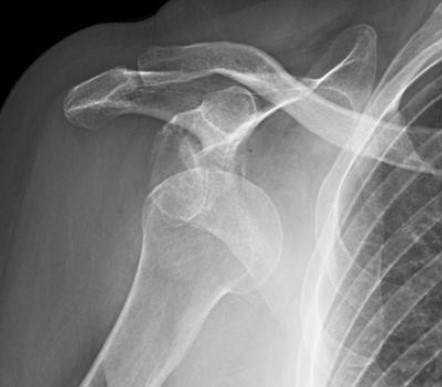

In [7]:
from IPython.display import Image
Image(filename="shoulder dislocation/p2.jpg", width=450, height=450)

  



###### While a standard shoulder looks like this:

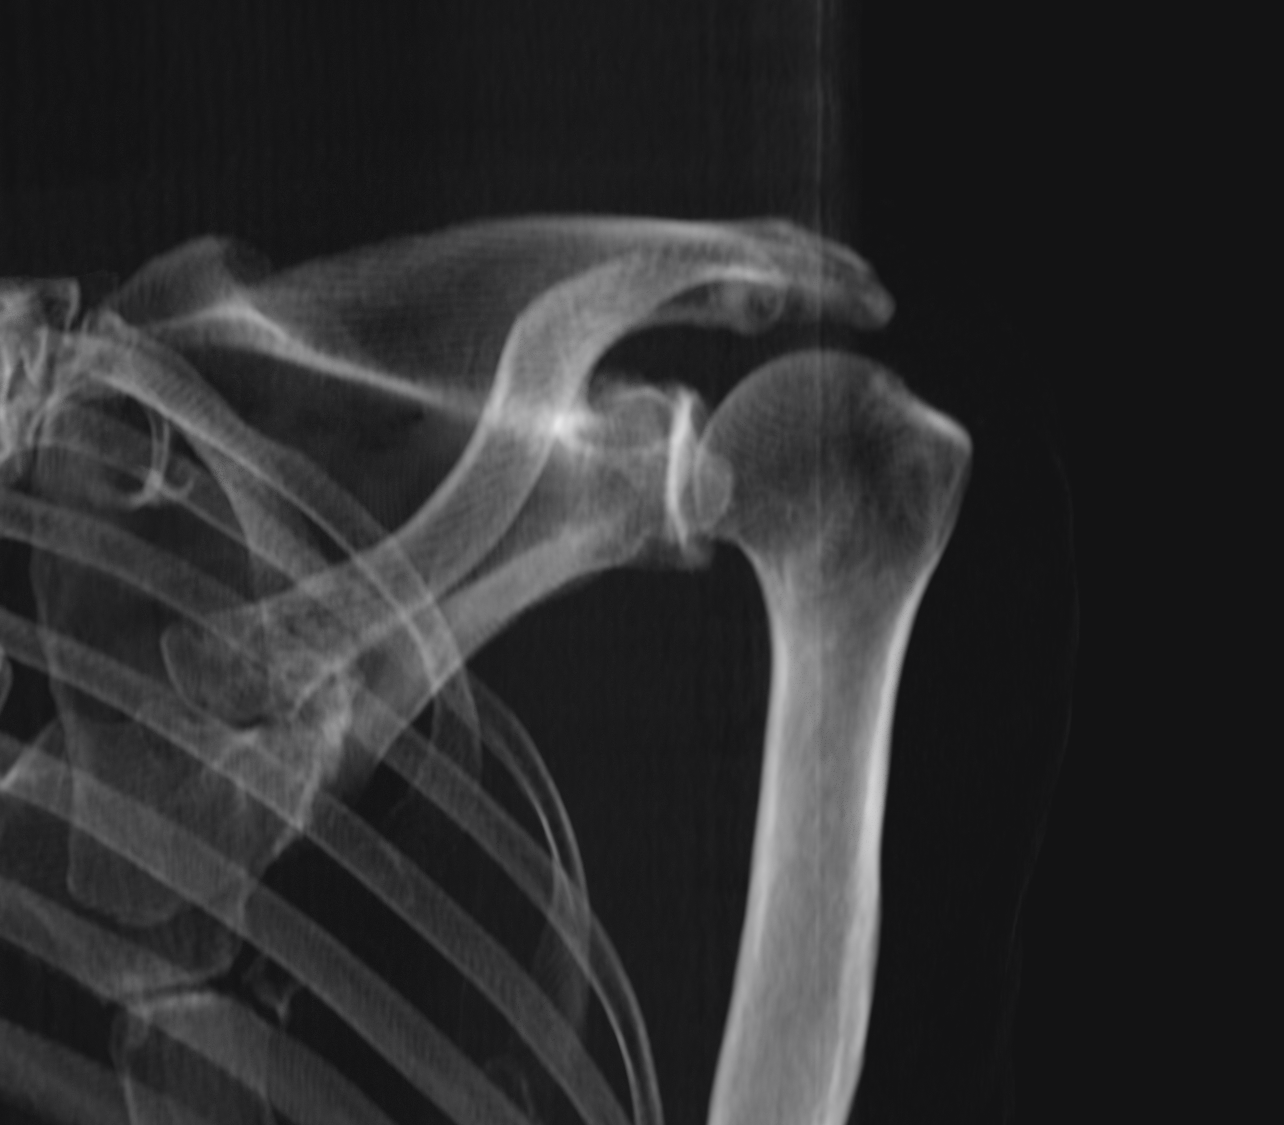

In [2]:
Image(filename="regular shoulders/pp1.png", width=450, height=450)





###### We can see that the diffrences between the shoulders is that in the dislocation, the rotator cuff detached from the collar bone that should wrap it.
###### So the diffrences we want focus on is the space between the rotator cuff to the collar bone
###### because in the dislocation the rotator cuff goes down

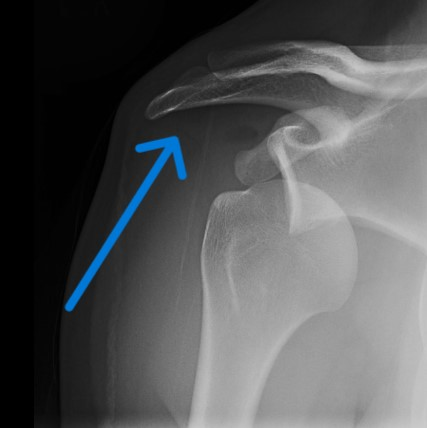

In [3]:
Image(filename="Scr.jpg", width=450, height=450)

## EDA


Let start with loading the data:




    

In [4]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import neighbors, datasets
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

In [5]:

plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.sans-serif'] = "Comic Sans MS"

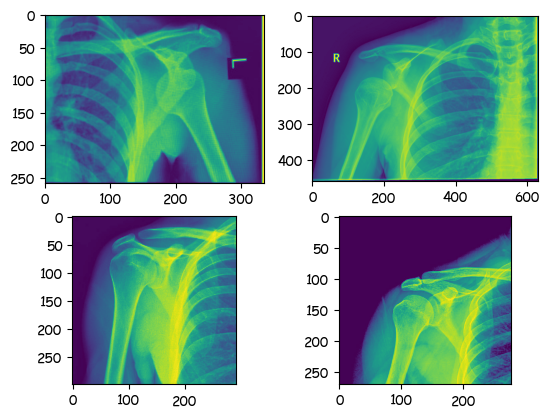

In [6]:

def load_images_from_folder(folder):
#    function that extract the pictures from the folder
    
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename), )
        if img is not None:
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) 
            images.append(gray)
    return images


dislocated = load_images_from_folder('shoulder dislocation')
regular = load_images_from_folder('regular shoulders')

plt.subplot(2, 2, 1)
plt.imshow(dislocated[0])
plt.subplot(2, 2, 2)
plt.imshow(dislocated[1])
plt.subplot(2, 2, 3)
plt.imshow(regular[0])
plt.subplot(2, 2, 4)
plt.imshow(regular[1])


The 2 upper images are dislocation and the lower images are not.

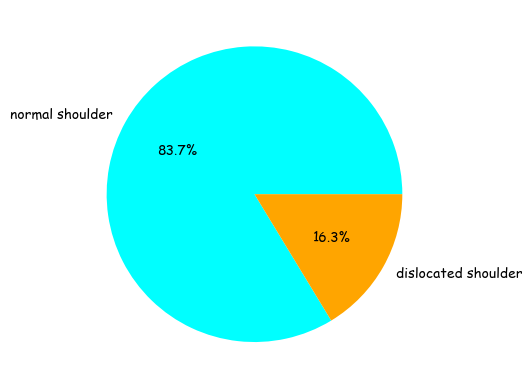

In [8]:
info = np.array([len(regular), len(dislocated)])
labels = ["normal shoulder", "dislocated shoulder"]
c = ["aqua", "orange"]
plt.pie(info, labels=labels ,autopct='%1.1f%%', colors=c)
plt.show()

###### We can see that there is much more pictures of a normal shoulder than dislocated ones


###### As we can see here the size of the image is pretty big so I will reduce the resolution of all the scans to 100 on 100

In [9]:
print(len(regular[3]), len(regular[3][0]))


1260 1249


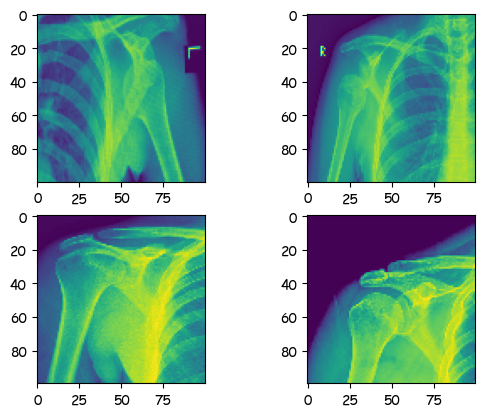

In [10]:

def reduce_resolution(scans):
    reduce_images = []
    for i in scans:
        length, width = len(i), len(i[0])
        skip_l, skip_w = length // 100, width // 100
        edge_l, edge_w = length % 100 // 2, width % 100 // 2
        x = i[edge_l: -(edge_l+1): skip_l, edge_w: -(edge_w+1): skip_w]
        if len(x) == 100 and len(x[0]) == 100:
            reduce_images.append(x)
    return reduce_images


regular_new = np.array(reduce_resolution(regular))
dislocated_new = np.array(reduce_resolution(dislocated))

plt.subplot(2, 2, 1)
plt.imshow(dislocated_new[0])
plt.subplot(2, 2, 2)
plt.imshow(dislocated_new[1])
plt.subplot(2, 2, 3)
plt.imshow(regular_new[0])
plt.subplot(2, 2, 4)
plt.imshow(regular_new[1])



###### As we can see the scans are still crystal clear

# First attempt - KNN
###### We will try to classify the shoulders by using the K nearset neighbors.
###### first we will divide the data to a train and test groups when the train set contains 80% 
###### of the data and the test set will contains the other 20% of the data.
###### of course we will set n to 2 becouse we want the algorithm to devide the data to 2 groups
###### the normal shoulders and ones for the dislocated shoulder.

In [11]:
data = np.concatenate((regular_new.reshape(-1, 10000), dislocated_new.reshape(-1, 10000)))
labels = np.concatenate((np.zeros(len(regular_new)), np.ones(len(dislocated_new))))
train_images, test_images, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state = 1)

In [12]:
clf = neighbors.KNeighborsClassifier(2, weights='uniform')
clf.fit(train_images, train_labels) 

KNeighborsClassifier(n_neighbors=2)

###### now let test the algorithm:

In [13]:
result = clf.predict(test_images)
matches = (result==test_labels)
correct = np.count_nonzero(matches)
accuracy = correct*100.0/result.size
print(accuracy) 

99.24242424242425


###### To our suprise we can see that the result gives us an amazing accurasy.
###### This is probably because when the KNN run on the part of the scan where the rotator cuff supposed be
###### that mean he supposed to meet wither pixels but he meet black pixels where he run over dislocation scan 
###### because in the part the rotator cuff the bones is not there (is below this part of the scan, because as I said 
###### in the beginning in dislocation the rotator cuff go down).

###### lets create confusion matrix to see where the algorithm fail.

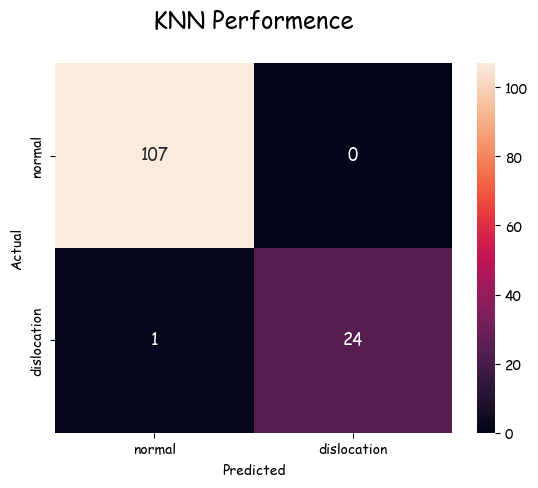

In [14]:
cmat = confusion_matrix(result, test_labels)
ax = sns.heatmap(cmat, annot=True, annot_kws={"size": 12}, fmt="g")
ax.set(xlabel='Predicted', ylabel='Actual')
ax.xaxis.set_ticklabels(['normal','dislocation'])
ax.yaxis.set_ticklabels(['normal','dislocation'])
ax.set_title("KNN Performence\n", fontsize=17)
plt.show()

###### The algorithm only miss ones in the test when he predicted a dislocated shoulder as normal shoulder
###### it almost as accurated as doctor whos in average  mistake ones in 200 people (the algorithm mistake ones in 130 poeple)
###### Let show his ability:

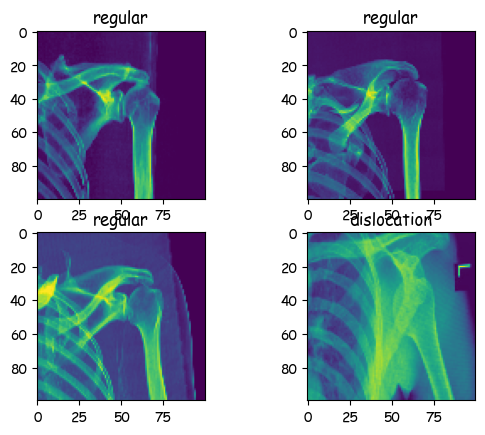

In [15]:
x = np.random.randint(131, size=(4))
scan = test_images[x]
predictions = clf.predict(scan)
scan = scan.reshape(-1, 100, 100)
plt.subplot(2, 2, 1)
plt.title("regular" if not predictions[0] else "dislocation")
plt.imshow(scan[0])
plt.subplot(2, 2, 2)
plt.title("regular" if not predictions[1] else "dislocation")
plt.imshow(scan[1])
plt.subplot(2, 2, 3)
plt.title("regular" if not predictions[2] else "dislocation")
plt.imshow(scan[2])
plt.subplot(2, 2, 4)
plt.title("regular" if not predictions[3] else "dislocation")
plt.imshow(scan[3])

###### I'll take the risk and say that as we expected he didn't wrong here

# Secound attempt- NN
###### now we will try to predicts the scans with neural networks
###### first we convert the data to be between 0 to 1, when 1 represent 255 pixle and 0 represent 0 pixle
###### and then we create our models the second model is more complicated then the first model to check if the more complexity
###### the model the better/ worse the results 

In [16]:
train_images = train_images / 255

###### We create the first model with 3 layers because we need one hidden layer and that because are data is not linearly separable.
###### The hidden layer gives the model to operate on more complax data such as we got, but nothing ensure us that the model with one
###### hidden layer is enough for separate our data that why we create a model with two hidden layers. 
###### If the second model will preforme better than the first model it's mean that our data is to complicated for being separated
###### with one hidden layer. If the second model will bring exellent results we wont create more complicte model
###### because this model will be enough.

In [17]:
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(100, 100)),  # input layer (1)
    keras.layers.Dense(256, activation='relu'),    # hidden layer (2)
    keras.layers.Dense(2, activation='sigmoid')    # output layer (3)
])

model2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(100, 100)),  # input layer (1)
    keras.layers.Dense(512, activation='relu'),    # hidden layer (2)
    keras.layers.Dense(32, activation='relu'),    # hidden layer (3)
    keras.layers.Dense(2, activation='sigmoid')    # output layer (4)
])

In [18]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 256)               2560256   
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 2560770 (9.77 MB)
Trainable params: 2560770 (9.77 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_2 (Dense)             (None, 512)               5120512   
                                                                 
 dense_3 (Dense)             (None, 32)                16416     
                                                                 
 dense_4 (Dense)             (None, 2)                 66        
                                                                 
Total params: 5136994 (19.60 MB)
Trainable params: 5136994 (19.60 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


###### We will optimize the models with diffrences optimizers because the stochastic gradient descent performs better for
###### the complicated model and the adaptive moment estimation performs better for the simpler model

In [20]:
model1.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

model2.compile(optimizer="SGD",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [21]:
hist1 = model1.fit(train_images.reshape(-1, 100, 100), train_labels, epochs=5)
hist2 = model2.fit(train_images.reshape(-1, 100, 100), train_labels, epochs=5)

Epoch 1/5
17/17 [==============================] - 6s 88ms/step - loss: 1.3372 - accuracy: 0.7405
Epoch 2/5
17/17 [==============================] - 1s 86ms/step - loss: 0.2470 - accuracy: 0.9261
Epoch 3/5
17/17 [==============================] - 2s 96ms/step - loss: 0.1050 - accuracy: 0.9886
Epoch 4/5
17/17 [==============================] - 1s 84ms/step - loss: 0.0684 - accuracy: 0.9924
Epoch 5/5
17/17 [==============================] - 2s 91ms/step - loss: 0.0626 - accuracy: 0.9905
Epoch 1/5
17/17 [==============================] - 3s 73ms/step - loss: 0.4753 - accuracy: 0.8466
Epoch 2/5
17/17 [==============================] - 1s 80ms/step - loss: 0.2606 - accuracy: 0.9318
Epoch 3/5
17/17 [==============================] - 1s 79ms/step - loss: 0.1750 - accuracy: 0.9716
Epoch 4/5
17/17 [==============================] - 1s 76ms/step - loss: 0.1417 - accuracy: 0.9848
Epoch 5/5
17/17 [==============================] - 1s 64ms/step - loss: 0.0982 - accuracy: 0.9886


###### Because of the fact that some random paramters are exist when we create a model we will save
###### the weights of the best model, what means that the presented model will probably be
###### better than what you see in the training here
###### If we want to save the weights we will use the code here:

In [ ]:
secure = input("are you sure you want to update the models? (y/n):  ")
if secure == 'y':
    model1_json = model1.to_json()
    with open("model1.json", "w") as json_file:
        json_file.write(model1_json)

    model1.save_weights("model1.h5")
    print("model 1 saved")

    model2_json = model2.to_json()
    with open("model2.json", "w") as json_file:
        json_file.write(model2_json)

    model2.save_weights("model2.h5")
    print("model 2 saved")
else:
    print("models 1 and 2 not saved")

In [22]:
json_file = open('model1.json', 'r')
loaded_model1_json = json_file.read()
json_file.close()
loaded_model1 = keras.models.model_from_json(loaded_model1_json)
loaded_model1.load_weights("model1.h5")
print("Loaded model 1")

json_file = open('model2.json', 'r')
loaded_model2_json = json_file.read()
json_file.close()
loaded_model2 = keras.models.model_from_json(loaded_model2_json)
loaded_model2.load_weights("model2.h5")
print("Loaded model 2")

Loaded model 1
Loaded model 2


In [23]:
loaded_model1.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

loaded_model2.compile(optimizer="SGD",
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])


test_loss1, test_acc1 = loaded_model1.evaluate(test_images.reshape(-1, 100, 100),  test_labels, verbose=1) 
test_loss2, test_acc2 = loaded_model2.evaluate(test_images.reshape(-1, 100, 100),  test_labels, verbose=1) 

5/5 [==============================] - 2s 46ms/step - loss: 10.2598 - accuracy: 0.9697


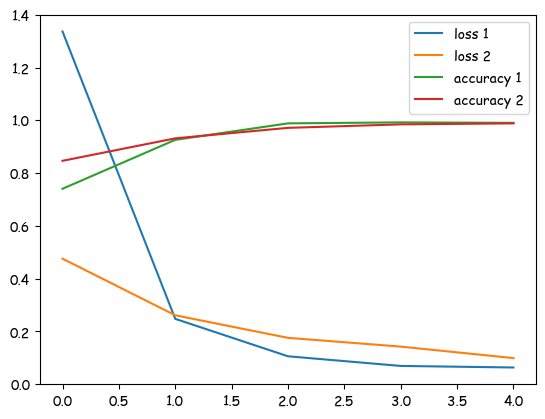

In [24]:
plt.plot(hist1.history['loss'])
plt.plot(hist2.history['loss'])
plt.plot(hist1.history['accuracy'])
plt.plot(hist2.history['accuracy'])
plt.legend(['loss 1', 'loss 2', 'accuracy 1', 'accuracy 2'])

###### We can see that the loss function crash very fast in the first model duo to his simpler form while
###### while the loss function of the second model start lower, and both of the loss functions converging with a similar derivative.
###### In both models the accuracy also converge very fast, that can explain the fast crash of the loss functions
###### but it seems that although there is a difference between the loss functions in the end, the accuracies converge into almost the
###### same value.

In [25]:
r = test_labels
prediction1 = loaded_model1.predict(test_images.reshape(-1, 100, 100))
p1 = np.argmax(prediction1, axis=-1)
print("accuracy of model 1: " + str(round((sum(p1 == r) / len(r)) * 100, 4)) + "%")

5/5 [==============================] - 1s 22ms/step
accuracy of model 1: 86.3636%


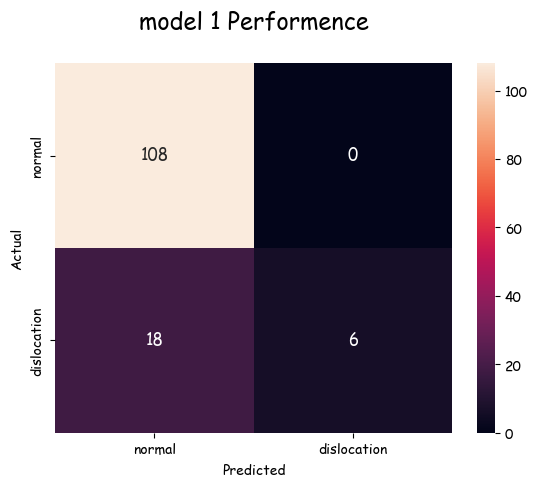

In [26]:
cmat = confusion_matrix(r, p1)
ax = sns.heatmap(cmat, annot=True, annot_kws={"size": 12}, fmt="g")
ax.set(xlabel='Predicted', ylabel='Actual')
ax.xaxis.set_ticklabels(['normal','dislocation'])
ax.yaxis.set_ticklabels(['normal','dislocation'])
ax.set_title("model 1 Performence\n", fontsize=17)
plt.show()

###### The model struggling with recognize the dislocated shoulders and predict 75% of the those shoulders as a normal soulder
###### that means he successed to identify a dislocated shoulder only in 25% of the cases, that a poor model, so lets
###### check how the preformance of second model, in hope that will give as a better results

In [27]:
prediction2 = loaded_model2.predict(test_images.reshape(-1, 100, 100))
p2 = np.argmax(prediction2, axis=-1)
print("accuracy of model 2: " + str(round((sum(p2 == r) / len(r)) * 100, 4)) + "%")

5/5 [==============================] - 0s 16ms/step
accuracy of model 2: 97.7273%


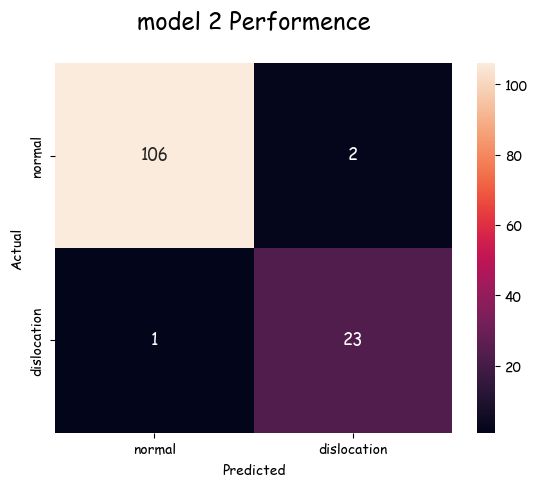

In [28]:
cmat = confusion_matrix(r, p2)
ax = sns.heatmap(cmat, annot=True, annot_kws={"size": 12}, fmt="g")
ax.set(xlabel='Predicted', ylabel='Actual')
ax.xaxis.set_ticklabels(['normal','dislocation'])
ax.yaxis.set_ticklabels(['normal','dislocation'])
ax.set_title("model 2 Performence\n", fontsize=17)
plt.show()

###### We can see that the model only mistake 3 times one when he predict a dislocated shoulder as normal one, 
###### and two normal shoulders that he predict as dislocated shoulders

# Third attempt - CNN
###### Until now we had some good results from model 2 but let see if we can improve the odel to give as a 
###### better results, so what we going to do is to implement the CNN architecture but in a simple form
###### that means we will add only one layer of convolution that will run 10 times and one pooling layer 
###### that will run ones. The reason we will use CNN architecture is for make the nueral network to "look"
###### more focused on the gap between the bones so the pooling layer will pool the white pixels if there are
###### exist where the rotator cuff should be in a normal shouder or black pixels if there is no white pixels in the
###### area what means that the scan is a dislocation.
###### After the pooling layer we flatten the data and it connects to two hidden layers because as we saw earlier, the two hidden layers 
###### work better than the one hidden layer.

In [29]:
model3 = keras.models.Sequential()
model3.add(keras.layers.Conv2D(10, (2, 2), activation='relu', input_shape=(100, 100, 1)))
model3.add(keras.layers.MaxPooling2D((2, 2)))
model3.add(keras.layers.Flatten())
model3.add(keras.layers.Dense(512, activation='relu'))
model3.add(keras.layers.Dense(32, activation='relu'))
model3.add(keras.layers.Dense(2))

In [30]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 99, 99, 10)        50        
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 10)        0         
 D)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 24010)             0         
                                                                 
 dense_5 (Dense)             (None, 512)               12293632  
                                                                 
 dense_6 (Dense)             (None, 32)                16416     
                                                                 
 dense_7 (Dense)             (None, 2)                 66        
                                                      

In [31]:
model3.compile(optimizer="adamax",
              loss="mse",
              metrics=['accuracy'])

In [32]:
hist3 = model3.fit(train_images.reshape(-1, 100, 100), train_labels, epochs=5)
test_loss3, test_acc3 = model3.evaluate(test_images.reshape(-1, 100, 100),  test_labels, verbose=1) 

Epoch 1/5
17/17 [==============================] - 15s 465ms/step - loss: 2.1580 - accuracy: 0.5492
Epoch 2/5
17/17 [==============================] - 8s 475ms/step - loss: 0.0683 - accuracy: 0.5095
Epoch 3/5
17/17 [==============================] - 8s 466ms/step - loss: 0.0333 - accuracy: 0.5303
Epoch 4/5
17/17 [==============================] - 9s 504ms/step - loss: 0.0243 - accuracy: 0.6534
Epoch 5/5
5/5 [==============================] - 2s 130ms/step - loss: 8689.3945 - accuracy: 0.6212


In [ ]:
secure = input("are you sure you want to update the model? (y/n):  ")
if secure == 'y':
    model3_json = model3.to_json()
    with open("model3.json", "w") as json_file:
        json_file.write(model3_json)

    model3.save_weights("model3.h5")
    print("model 3 saved")
else:
    print("model 3 not saved")

In [33]:
json_file = open('model3.json', 'r')
loaded_model3_json = json_file.read()
json_file.close()
loaded_model3 = keras.models.model_from_json(loaded_model3_json)
loaded_model3.load_weights("model3.h5")
print("Loaded model 3")

Loaded model 3


In [34]:
loaded_model3.compile(loss='sparse_categorical_crossentropy', optimizer='Adagrad', metrics=['accuracy'])
test_loss3, test_acc3 = loaded_model3.evaluate(test_images.reshape(-1, 100, 100),  test_labels, verbose=1) 

5/5 [==============================] - 1s 80ms/step - loss: 0.6826 - accuracy: 0.9924


In [35]:
prediction3 = loaded_model3.predict(test_images.reshape(-1, 100, 100))
p3 = np.argmax(prediction3, axis=-1)
print("accuracy of model 3: " + str(round((sum(p3 == r) / len(r)) * 100, 4)) + "%")

5/5 [==============================] - 1s 107ms/step
accuracy of model 3: 99.2424%


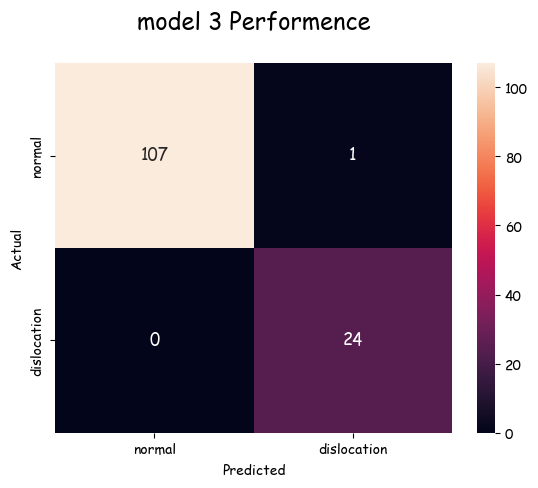

In [36]:
cmat = confusion_matrix(r, p3)
ax = sns.heatmap(cmat, annot=True, annot_kws={"size": 12}, fmt="g")
ax.set(xlabel='Predicted', ylabel='Actual')
ax.xaxis.set_ticklabels(['normal','dislocation'])
ax.yaxis.set_ticklabels(['normal','dislocation'])
ax.set_title("model 3 Performence\n", fontsize=17)
plt.show()

###### We can see here a remarkable results, the model was only miss ones when he predict a normal sholder
###### as a dislocated shoulder, it equal to the preformence of the KNN except where they make the mistake.

In [37]:
data = {
  "KNN":{
    "precentage:":round(accuracy, 2)
  },
  "model 1":{
    "precentage:":round((sum(p1 == r) / len(r)) * 100, 2)
  },
  "model 2":{
  "precentage:":round((sum(p2 == r) / len(r)) * 100, 2)
  },
  "model 3 (CNN)":{
  "precentage:":round((sum(p3 == r) / len(r)) * 100, 2)
  }
}

df = pd.DataFrame(data)

# Summary
###### In this project we tried to classify scans of shoulders to normal ones and dislocated ones
###### all of the models worked fine, some of them even worked incredibly good and accurate
###### We got the chance to work with:
######    1. K nearest neighbors algorithm
######    2. neural network built from 3 layers and with adam optimizer and 
######        sparse categorical crossentropy loss function
######    3. neural network built from 4 layers and with SGD optimizer and 
######        sparse categorical crossentropy loss function
######    4. CNN architecture with adamax optimizer and mean squared error loss function

###### Here we can  see the results from several angles:
###### The accuracy:

In [38]:
print(df) 

               KNN  model 1  model 2  model 3 (CNN)
precentage:  99.24    86.36    97.73          99.24


###### For understanding better the models results I will use ROC curve- a graph that represent the sensitivity (TPR) 
###### as a dependency in the specificity (FPR), this will show us (similarly to confusioin matrix the best model) the preformance of the model
###### when the best model is the one that comes to the highest TPR (1) with the lowest FPR 

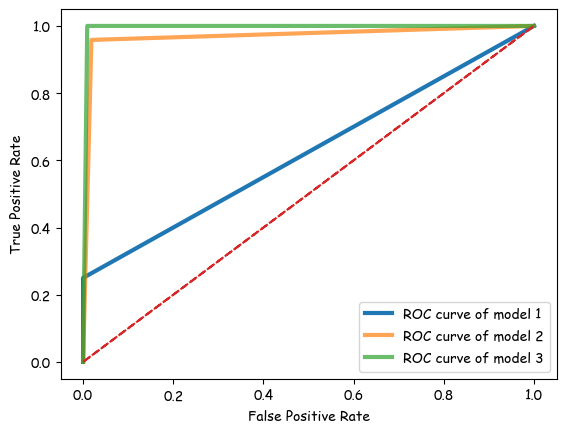

In [39]:
fpr, tpr, thresholds = roc_curve(r, p1)
plt.plot(fpr, tpr, linewidth=3.0, linestyle='-')
fpr, tpr, thresholds = roc_curve(r, p2)
plt.plot(fpr, tpr, linewidth=3.0, linestyle='-', alpha=0.7)
fpr, tpr, thresholds = roc_curve(r, p3)
plt.plot(fpr, tpr, linewidth=3.0, linestyle='-', alpha=0.7)
plt.plot(r, r, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(['ROC curve of model 1', 'ROC curve of model 2', 'ROC curve of model 3'])

###### We can see that model 3 (97% accuracy) and model 2 (99% accuracy) are very close to a perfect true rate
###### while model 1 in 0.25 increase his false rate
###### model 3 (CNN) show the best results in our ROC curve.

# Conclution
###### We run through few algorithms, the best algorithm in this project for classify dislocated shoulder is the CNN model
###### because althought that the KNN got the same results, the KNN classify a dislocated shoulder as normal one
###### and this is way worse then classify a normal shoulder as dislocated one, and the CNN got exellend results in the ROC curve.
###### I hope that someday when I'll have access to a bigger data set I'll do a further research on classifing dislocated shoulder
###### in hope to incorporate this into the medical industry for making the proccess of getting back in place the dislocated shoulder faster.

### The Data
###### The data I worked on was from [kaggle](https://www.kaggle.com/datasets/dryari5/shoulder-xray-classification) for the normal shoulders scans
###### For the dislocated sholders scan I had to collect individually every scan (even used my own scan)

## Thanks for reading my notebook!